In [19]:
using Random
using KernelDensity
include("../Inversion/AffineInvariantMCMC.jl")
include("../Inversion/NGFlow.jl")
include("../Inversion/GMWVI.jl")
include("../Inversion/BBVI.jl")
include("../Inversion/Plot.jl")
include("./MultiModal.jl")

Gaussian_mixture_VI (generic function with 1 method)

In [20]:
function visualization_comparison_2d(ax, obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = 200, Ny = 200, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0],
    func_F = nothing, func_Phi = nothing, bandwidth=nothing, make_label::Bool=false, N_iter=500)
    
    x_min, x_max = x_lim
    y_min, y_max = y_lim

    xx = LinRange(x_min, x_max, Nx)
    yy = LinRange(y_min, y_max, Ny)
    dx, dy = xx[2] - xx[1], yy[2] - yy[1]
    X,Y = repeat(xx, 1, Ny), repeat(yy, 1, Nx)'

    Z_ref = (func_Phi === nothing ? posterior_2d(func_F, X, Y, "func_F") : posterior_2d(func_Phi, X, Y, "func_Phi"))
    color_lim = (minimum(Z_ref), maximum(Z_ref))
    ax[1].pcolormesh(X, Y, Z_ref, cmap="viridis", clim=color_lim)

    error = zeros(5, N_iter+1)

    #NGF-VI
    if obj_NGFlow!=nothing
        for iter = 0:N_iter
            x_w = exp.(obj_NGFlow.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj_NGFlow.x_mean[iter+1][:,1:2]
            xx_cov = obj_NGFlow.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[1, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
        
                ax[2].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                # N_modes = size(x_mean, 1)
                ax[2].scatter([obj_NGFlow.x_mean[1][:,1];], [obj_NGFlow.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[2].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
            
            end
        end
    end

    #NGF-VI-D
    if obj_NGFlow_D!=nothing
        for iter = 0:N_iter
            x_w = exp.(obj_NGFlow_D.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj_NGFlow_D.x_mean[iter+1][:,1:2]
            xx_cov = obj_NGFlow_D.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[2, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
        
                ax[3].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                # N_modes = size(x_mean, 1)
                ax[3].scatter([obj_NGFlow_D.x_mean[1][:,1];], [obj_NGFlow_D.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[3].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
            
            end
        end
    end

    #GMWVI
    if obj_GMWVI!=nothing
        for iter = 0:N_iter
            x_w = exp.(obj_GMWVI.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj_GMWVI.x_mean[iter+1][:,1:2]
            xx_cov = obj_GMWVI.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[3, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
        
                ax[4].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[4].scatter([obj_GMWVI.x_mean[1][:,1];], [obj_GMWVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[4].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
            
            end
        end
    end
    
    #BBVI
    if obj_BBVI !=nothing
        for iter = 0:N_iter
            x_w = exp.(obj_BBVI.logx_w[iter+1]); x_w /= sum(x_w)
            x_mean = obj_BBVI.x_mean[iter+1][:,1:2]
            xx_cov = obj_BBVI.xx_cov[iter+1][:,1:2,1:2]
            Z = Gaussian_mixture_2d(x_w, x_mean, xx_cov,  X, Y)
            error[4, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
        
                ax[5].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[5].scatter([obj_BBVI.x_mean[1][:,1];], [obj_BBVI.x_mean[1][:,2];], marker="x", color="grey", alpha=0.5) 
                ax[5].scatter([x_mean[:,1];], [x_mean[:,2];], marker="o", color="red", facecolors="none", alpha=0.5)
            
            end
        end
    end

    #MCMC
    if ens_MCMC !=nothing
        boundary=((x_lim[1],x_lim[2]),(y_lim[1],y_lim[2]))
        for iter = 0:N_iter

            if bandwidth==nothing
                kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny))
            else
                kde_iter=kde(ens_MCMC[:,:,iter+1]';boundary=boundary,npoints=(Nx,Ny),bandwidth=bandwidth)
            end

            Z = kde_iter.density/(sum(kde_iter.density)*dx*dy)
            error[5, iter+1] = norm(Z - Z_ref,1)*dx*dy
            
            if iter == N_iter
                
                last_n_iters=10  #use the last "last_n_iters" iterations to draw pictures
                last_ens=hcat([ens_MCMC[:,:,i] for i in N_iter+2-last_n_iters:N_iter+1]...)
                last_ens_number=size(last_ens,2)

                if bandwidth==nothing
                    kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny))
                else
                    kde_last=kde(last_ens'; boundary=boundary, npoints=(Nx,Ny), bandwidth=bandwidth)
                end

                Z = kde_last.density/(sum(kde_last.density)*dx*dy)

                ax[6].pcolormesh(X, Y, Z, cmap="viridis", clim=color_lim)
                ax[6].scatter(last_ens[1,:], last_ens[2,:], marker=".", color="red", s=10, alpha=100/last_ens_number)
                ax[6].set_xlim(x_lim)
                ax[6].set_ylim(y_lim)

            end
        end
    end
    
    ax[7].semilogy(Array(0:N_iter), error', label=["NGF-VI","NGF-VI-D","WGF-VI","BBVI","MCMC"])   
    
    if make_label==true
        ax[7].legend()
    end

    # Get the current y-axis limits
    ymin, ymax = ax[7].get_ylim()
    # Ensure the lower bound of y-ticks is below 0.1
    if ymin > 0.1
         ax[7].set_ylim(0.1, ymax)  # Set the lower limit to a value below 0.1
    end

end

visualization_comparison_2d (generic function with 1 method)

[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("iter = ", 160, " / ", 200)
[ Info: ("iter = ", 180, " / ", 200)
[ Info: ("iter = ", 200, " / ", 200)
[ Info: ("iter = ", 20, " / ", 200)
[ Info: ("iter = ", 40, " / ", 200)
[ Info: ("iter = ", 60, " / ", 200)
[ Info: ("iter = ", 80, " / ", 200)
[ Info: ("iter = ", 100, " / ", 200)
[ Info: ("iter = ", 120, " / ", 200)
[ Info: ("iter = ", 140, " / ", 200)
[ Info: ("ite

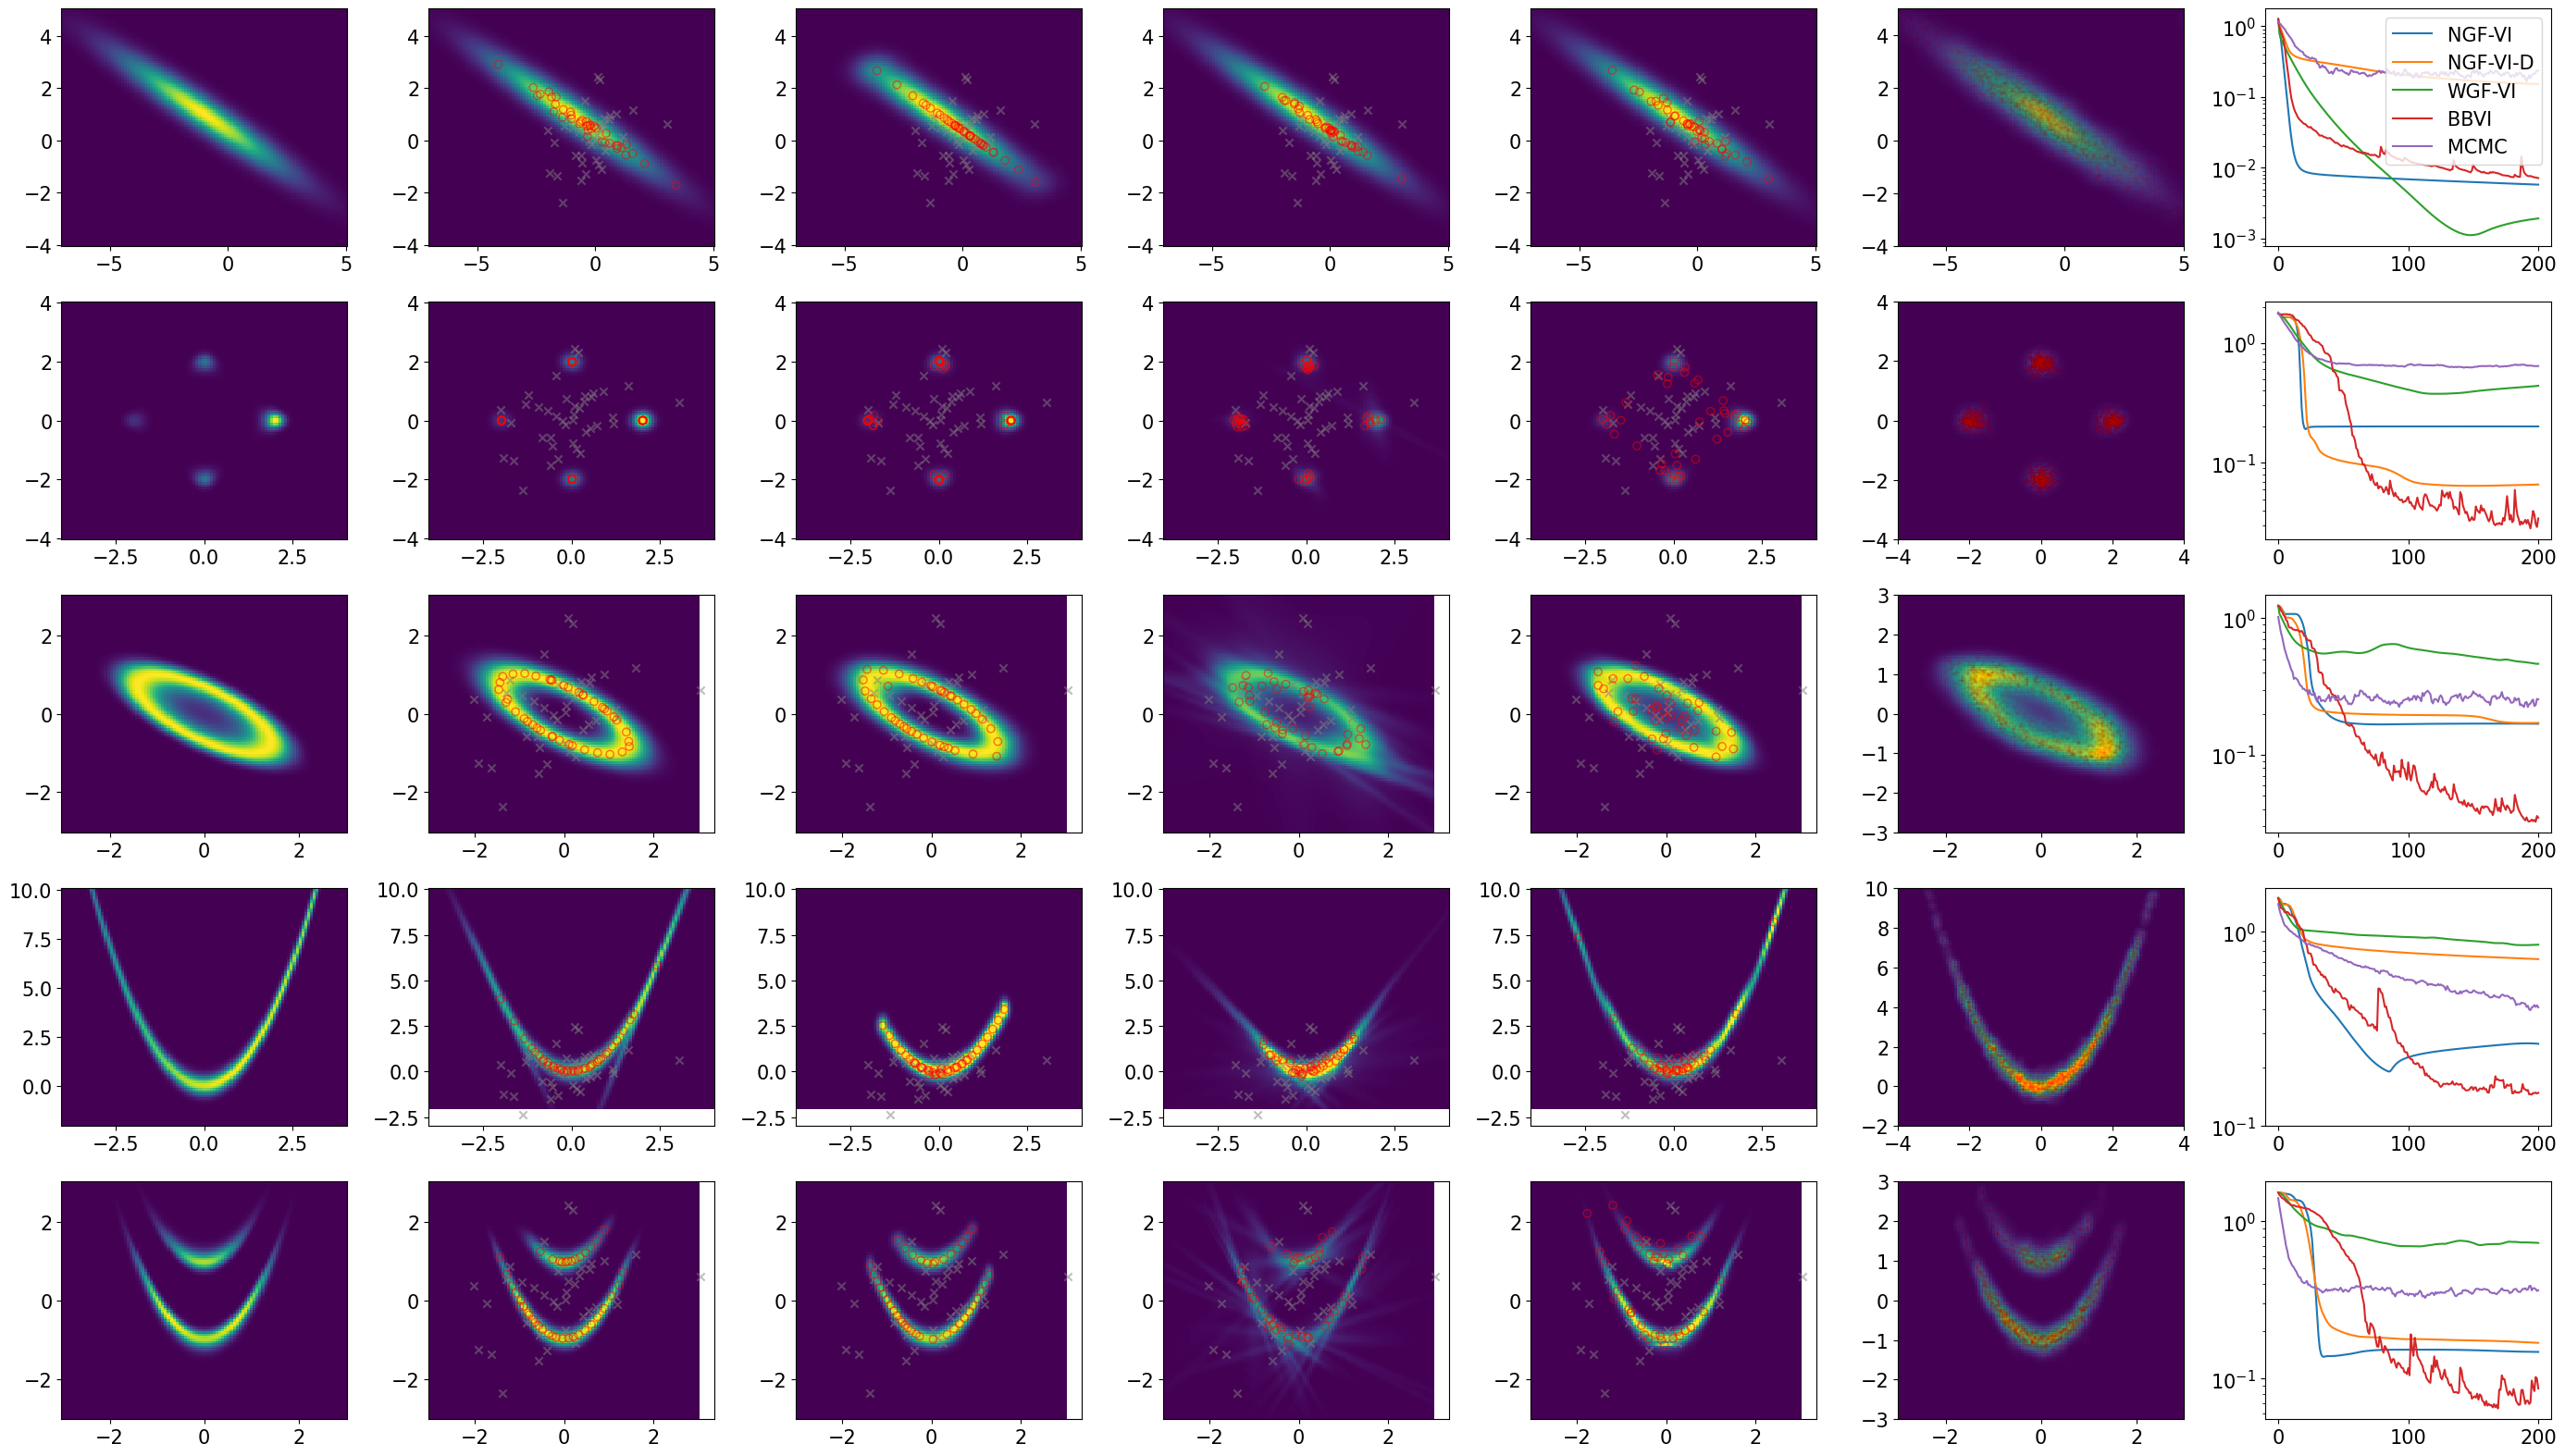

In [21]:
N_modes = 40 # number of modes in Gaussian mixture
N_ens= 1000 # number of paticles in MCMC
N_bbvi_sample = 50 # number of samples to compute expectation using Monte Carlo in BBVI
 

fig, ax = PyPlot.subpl ots(nrows=5, ncols=7, sharex=false, sharey=false, figsize=(28,16))


Random.seed!(111);
x0_w  = ones(N_modes)/N_modes
μ0, Σ0 = [0.0; 0.0], [1.0 0.0; 0.0 1.0]
N_x = length(μ0)
x0_mean, xx0_cov = zeros(N_modes, N_x), zeros(N_modes, N_x, N_x)
for im = 1:N_modes
    x0_mean[im, :]    .= rand(MvNormal(zeros(N_x), Σ0)) + μ0
    xx0_cov[im, :, :] .= Σ0
end
Hessian_correct_GM = false
ens_0=zeros(N_x,N_ens)
for j = 1:N_ens
    ens_0[:,j]  = rand(MvNormal(zeros(N_x), Σ0)) + μ0
end

N_iter = 200
Nx, Ny = 100,100



ση = 1.0
Gtype = "Gaussian"
dt1 = dt3 = dt4 = 0.5
dt2 = 1.4e-1 
A = [1.0 1.0; 1.0 2.0]
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))
func_Phi(x)= -logrho(x, func_args)

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1)[1]
obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3)[1]
obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

visualization_comparison_2d(ax[1,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-7.0, 5.0], y_lim=[-4.0, 5.0], func_F=func_F, 
    bandwidth=(0.32,0.22), make_label=true,  N_iter= N_iter)



ση = 1.0
Gtype = "Four_modes"
dt1 = dt3 = dt4 = 0.5
dt2 = 5e-3
y = [4.2297; 4.2297; 0.5; 0.0; zeros(N_x-2)]
func_args = (y, ση, 0, Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1)[1]
obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3)[1]
obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

visualization_comparison_2d(ax[2,:],  obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-4, 4], func_F=func_F, 
    bandwidth=(0.14,0.14), make_label=false,  N_iter= N_iter)



ση = [0.5; ones(N_x-2)]
Gtype = "Circle"
dt1 = dt3 = dt4 = 0.5
dt2 = 5e-3
A = [1.0 1.0; 1.0 2.0]
y = [1.0; zeros(N_x-2)]
func_args = (y, ση, A , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1)[1]
obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3)[1]
obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

visualization_comparison_2d(ax[3,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.20,0.14), make_label=false,  N_iter= N_iter)



ση = [sqrt(10.0); sqrt(10.0); ones(N_x-2)]
Gtype = "Banana"
dt1 = dt3 = dt4 = 0.5
dt2 = 4e-3
λ = 10.0
y = [0.0; 1.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1)[1]
obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi,nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3)[1]
obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

visualization_comparison_2d(ax[4,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-4.0, 4.0], y_lim=[-2.0, 10.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)



ση = [0.3; 1.0; 1.0; ones(N_x-2)]
Gtype = "Double_banana"
dt1 = dt3 = dt4 = 0.5
dt2 = 8e-4
λ = 100.0
y = [log(λ+1); 0.0; 0.0; zeros(N_x-2)]
func_args = (y, ση, λ , Gtype)
func_F(x) = F(x, func_args)
func_dPhi(x) = dPhi(x, func_args)
func_prob(x)=exp(logrho(x, func_args))

obj_NGFlow = Gaussian_mixture_NGFVI(func_dPhi, nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = false, N_iter = N_iter, dt = dt1)[1]
obj_NGFlow_D = Gaussian_mixture_NGFVI(func_dPhi, nothing, x0_w, x0_mean, xx0_cov; diagonal_covariance = true, N_iter = N_iter, dt = dt3)[1]
obj_GMWVI = Gaussian_mixture_WGFVI(func_dPhi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt2, Hessian_correct_GM=Hessian_correct_GM)[1]
obj_BBVI = Gaussian_mixture_BBVI(func_Phi, x0_w, x0_mean, xx0_cov; N_iter = N_iter, dt = dt4, N_ens=N_bbvi_sample)
ens_MCMC=Run_StretchMove(ens_0,func_prob; output="History", N_iter=N_iter)

visualization_comparison_2d(ax[5,:], obj_NGFlow, obj_NGFlow_D, obj_GMWVI, obj_BBVI, ens_MCMC ; Nx = Nx, Ny = Ny, x_lim=[-3.0, 3.0], y_lim=[-3.0, 3.0], func_F=func_F, 
    bandwidth=(0.06,0.11), make_label=false,  N_iter= N_iter)


    
fig.tight_layout()
fig.savefig("MultiModal-Comparison-2D.pdf")